# Определение перспективного тарифа для телеком-компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов 

#### Тариф «Смарт» 
Ежемесячная плата: 550 рублей.  
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика.  
Стоимость услуг сверх тарифного пакета:  
1. минута разговора:  3 рубля ;  
2. сообщение: 3 рубля;  
3. 1 Гб интернет-трафика: 200 рублей.

#### Тариф «Ультра» 
Ежемесячная плата: 1950 рублей.  
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика.  
Стоимость услуг сверх тарифного пакета:  
1. минута разговора: 1 рубль;  
2. сообщение: 1 рубль;  
3. 1 Гб интернет-трафика: 150 рублей.

## Шаг 1. Изучение данных.

Импортируем необходимые библиотеки.

In [ ]:
import pandas as pd
import numpy as np
from math import factorial
from matplotlib import pyplot as plt
from scipy import stats as st
import scipy.stats
import math as mt
from matplotlib import pyplot as plt

Импортируем данные.

In [ ]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Ознакомимся с датасетами.

Общая информация о тарифах.

In [ ]:
display(tariffs)
tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Пропусков нет.
Типы данных корректные.

Информация о пользователях.

In [ ]:
display(users.head())
users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Имеются пропуски в столбце `churn_date`, этот столбец отображает дату окончания пользования тарифом и логично, что если ячейка пуста, то тариф продолжает действовать для пользователя.
Поэтому бороться с этими пропуками нет необходимости.
Типы данных также корректны.

Информация о звонках.

In [ ]:
display(calls)
calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Пропусков нет. Типы данных корректны, но нам известно, что оператор округляет время разговора до минут.
Поэтому логично будет округлить значения до целы и изменит тип данных на целочисленный.
Кроме того, в столбце `duration` содержатся нулевые значение, по условиям это пропущенные вызовы, поэтому не будем от них избавляться.

Информация о сообщениях.

In [ ]:
display(messages.head(10))
messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Пропусков нет. Типы данных корректны.

Информация об интернет сессиях.

In [ ]:
display(internet.head(10)) 
internet.info()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


В теблице оказалось два столбца с индексами, от одного из них нужно бы избавиться. Столбец `mb_used` содержит количество потраченых МБ за сессию. Оператор округляет мб до ГБ, но делает это лишь по итогу месяца. А для каждой сессии предлагаю округлить данные до МБ и изменить тип данных на целочисленный.

### Вывод 
Ознакомились с данными, нашли несколько проблем:
- в столбце `churn_date` имеются пропуски, но заполнять их не имеет смысла;
- для столбцов `duration` и `mb_used` необходимо осуществить округление до целого и изменить тип данных на целочисленный;
- в таблице `internet` необходимо избавится от одного столбца с индексацией.

## Шаг 2. Подготовка данных.

Для начала обработаем данные исходя из выводов сделанных в предыдущем шаге.

Округлим значения в столбцах `duration` из таблицы `calls` и `mb_used` из таблицы `internet` до целого и переведем в тип int

In [ ]:
calls['duration'] = np.ceil(calls['duration']).astype('int')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


В таблице `internet` неободимо избавиться от второго столбца с индексацией.

In [ ]:
internet = internet.drop(columns='Unnamed: 0')
internet

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


Данные приведены в порядок.

Теперь посчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам и запишем в таблицу `data_calls`;
- количество отправленных сообщений по месяцам и запишем в таблицу `data_messages`;
- объем израсходованного интернет-трафика по месяцам  запишем в таблицу `data_internet`;
- помесячную выручку с каждого пользователя


Создадим новую таблицу `data` и добавим туда столбцы с `user_id` и `tariff` .

In [ ]:
data = users[['user_id', 'tariff']].reset_index(drop=True)
display(data.head())

,user_id,tariff
0,1000,ultra
1,1001,smart
2,1002,smart
3,1003,ultra
4,1004,ultra


Добавим в таблицу со звонками столбец с месяцем звонка.

In [ ]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


Добавим в таблицу `data_calls` для каждого пользователя по каждому месяцу сумму потраченых минут и количество звонков.

In [ ]:
data_calls = calls.groupby(['user_id', 'month'], as_index=False).agg({'duration': 'sum', 'id': 'count'})
data_calls.rename(columns={'duration':'duration_sum', 'id':'count'}, inplace=True)
data_calls

,user_id,month,duration_sum,count
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58
...,...,...,...,...
3169,1498,10,247,41
3170,1499,9,70,9
3171,1499,10,449,68
3172,1499,11,612,74


Добавим в таблицу с данными о сообщениях столбец с месяцем отправления сообщения.

In [ ]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


Добавим в таблицу `data_messages` для каждого пользователя по каждому месяцу количество отправленых сообщений.

In [ ]:
data_messages = messages.groupby(['user_id', 'month'], as_index=False).agg({'id': 'count'})
data_messages.rename(columns={'id':'messages'}, inplace=True)
data_messages

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


Добавим в таблицу с данными о интернет сессиях столбец с месяцем сессии.

In [ ]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


Добавим в таблицу `data_internet` объем израсходованного интернет-трафика по месяцам запишем для каждого пользователя.

In [ ]:
data_internet = internet.groupby(['user_id', 'month'], as_index=False).agg({'mb_used': 'sum'})
data_internet.rename(columns={'mb_used':'mb_used_sum'}, inplace=True)
print(' ')
print('Сумма трафика в МБ')
data_internet

 
Сумма трафика в МБ


,user_id,month,mb_used_sum
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
...,...,...,...
3198,1498,10,20579.36
3199,1499,9,1845.75
3200,1499,10,17788.51
3201,1499,11,17963.31


Мы знаем, что оператор округляем месячный трафик до ГБ. Поэтому переведем суммы трафика в ГБ и округлим до целого.

In [ ]:
data_internet['mb_used_sum'] = np.ceil(data_internet['mb_used_sum']/1024).astype(int)
print(' ')
print('Сумма трафика в ГБ')    
display(data_internet)

 
Сумма трафика в ГБ


,user_id,month,mb_used_sum
0,1000,5,3
1,1000,6,23
2,1000,7,14
3,1000,8,14
4,1000,9,15
...,...,...,...
3198,1498,10,21
3199,1499,9,2
3200,1499,10,18
3201,1499,11,18


Теперь нам необходимо рассчитать помесячную прибыль с каждого пользователя.
Мы знаем, что абонентская плата пользователей с тарифом Смарт - 550 руб в месяц, а пользователей с тарифом Ультра - 1950 руб.
Заполним ячейки после даты регистрации суммой абонентский платы для каждого пользователя в зависимости от тарифа.

Добавим в таблицу о пользователях столбец с месяцем регистрации и месяцем окончания использования тарифа.

In [ ]:
users['month_reg'] = pd.DatetimeIndex(users['reg_date']).month
users['month_end'] = pd.DatetimeIndex(users['churn_date']).month
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month_reg,month_end
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,NaN
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11,NaN
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,NaN
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,8,NaN
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5,NaN
...,...,...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,8,NaN
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart,1,NaN
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart,10,NaN
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,7,10.0


Так как мы знаем, что изучаем данные только за 1 календарный год, то для простоты расчетом заменим пропущенные значения в столюце `month_end` на 12 - последний месяц в году.

In [ ]:
users['month_end']=users['month_end'].fillna(12).astype(int)
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month_reg,month_end
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,12
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11,12
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,12
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,8,12
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5,12
...,...,...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,8,12
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart,1,12
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart,10,12
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,7,10


Добавим столбец с месяцами, в которые начислялась абонентская плата.

In [ ]:
data_pay = pd.DataFrame(columns=['user_id', 'tariff', 'month'])

for i in range(len(users['user_id'])):
    j=users.loc[i, 'month_reg']
    while j <= users.loc[i, 'month_end']:
        data_pay = data_pay.append({'user_id': users.loc[i, 'user_id'], 'tariff': users.loc[i, 'tariff'], 'month': j}, ignore_index=True)
        j=j+1

display(data_pay.head(10))

,user_id,tariff,month
0,1000,ultra,5
1,1000,ultra,6
2,1000,ultra,7
3,1000,ultra,8
4,1000,ultra,9
5,1000,ultra,10
6,1000,ultra,11
7,1000,ultra,12
8,1001,smart,11
9,1001,smart,12


Начнем расчет суммы, которую пользователи ежемесячно платили за услуги связи.
Соединим нашу таблицу оплаты, с таблицей тарифов.

In [ ]:
data_pay['pay'] = 0
data_pay = data_pay.merge(tariffs, how='inner', left_on='tariff', right_on='tariff_name')
data_pay = data_pay.drop(columns = 'tariff_name')
data_pay

,user_id,tariff,month,pay,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,ultra,5,0,1000,30720,3000,1950,150,1,1
1,1000,ultra,6,0,1000,30720,3000,1950,150,1,1
2,1000,ultra,7,0,1000,30720,3000,1950,150,1,1
3,1000,ultra,8,0,1000,30720,3000,1950,150,1,1
4,1000,ultra,9,0,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,smart,10,0,50,15360,500,550,200,3,3
3212,1499,smart,9,0,50,15360,500,550,200,3,3
3213,1499,smart,10,0,50,15360,500,550,200,3,3
3214,1499,smart,11,0,50,15360,500,550,200,3,3


Переведем столбец `mb_per_month_included` в ГБ и сохраним в столбце `gb_per_month_included`.
А старый удалим.

In [ ]:
data_pay['gb_per_month_included'] = (data_pay['mb_per_month_included']/1024).astype(int)
data_pay = data_pay.drop(columns = 'mb_per_month_included')
data_pay

,user_id,tariff,month,pay,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,ultra,5,0,1000,3000,1950,150,1,1,30
1,1000,ultra,6,0,1000,3000,1950,150,1,1,30
2,1000,ultra,7,0,1000,3000,1950,150,1,1,30
3,1000,ultra,8,0,1000,3000,1950,150,1,1,30
4,1000,ultra,9,0,1000,3000,1950,150,1,1,30
...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,smart,10,0,50,500,550,200,3,3,15
3212,1499,smart,9,0,50,500,550,200,3,3,15
3213,1499,smart,10,0,50,500,550,200,3,3,15
3214,1499,smart,11,0,50,500,550,200,3,3,15


Теперь начислим абонентскую плату, которая ежемесячно начисляется в зависимости от тарифного плана. И удалим столбец `rub_monthly_fee`.

In [ ]:
data_pay['pay'] = data_pay['rub_monthly_fee']
data_pay = data_pay.drop(columns = 'rub_monthly_fee')
data_pay

,user_id,tariff,month,pay,messages_included,minutes_included,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,ultra,5,1950,1000,3000,150,1,1,30
1,1000,ultra,6,1950,1000,3000,150,1,1,30
2,1000,ultra,7,1950,1000,3000,150,1,1,30
3,1000,ultra,8,1950,1000,3000,150,1,1,30
4,1000,ultra,9,1950,1000,3000,150,1,1,30
...,...,...,...,...,...,...,...,...,...,...
3211,1498,smart,10,550,50,500,200,3,3,15
3212,1499,smart,9,550,50,500,200,3,3,15
3213,1499,smart,10,550,50,500,200,3,3,15
3214,1499,smart,11,550,50,500,200,3,3,15


In [ ]:
data_calls['id'] = data_calls['user_id'].astype(str) + '_' + data_calls['month'].astype(str)
data_calls

,user_id,month,duration_sum,count,id
0,1000,5,159,22,1000_5
1,1000,6,172,43,1000_6
2,1000,7,340,47,1000_7
3,1000,8,408,52,1000_8
4,1000,9,466,58,1000_9
...,...,...,...,...,...
3169,1498,10,247,41,1498_10
3170,1499,9,70,9,1499_9
3171,1499,10,449,68,1499_10
3172,1499,11,612,74,1499_11


In [ ]:
data_pay['id'] = data_pay['user_id'].astype(str) + '_' + data_pay['month'].astype(str)
data_pay = data_pay.merge(data_calls[['duration_sum', 'id']], on = ['id'], how='left')
data_pay

,user_id,tariff,month,pay,messages_included,minutes_included,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,id,duration_sum
0,1000,ultra,5,1950,1000,3000,150,1,1,30,1000_5,159.0
1,1000,ultra,6,1950,1000,3000,150,1,1,30,1000_6,172.0
2,1000,ultra,7,1950,1000,3000,150,1,1,30,1000_7,340.0
3,1000,ultra,8,1950,1000,3000,150,1,1,30,1000_8,408.0
4,1000,ultra,9,1950,1000,3000,150,1,1,30,1000_9,466.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,smart,10,550,50,500,200,3,3,15,1498_10,247.0
3212,1499,smart,9,550,50,500,200,3,3,15,1499_9,70.0
3213,1499,smart,10,550,50,500,200,3,3,15,1499_10,449.0
3214,1499,smart,11,550,50,500,200,3,3,15,1499_11,612.0


Расчитаем, есть ли привешение лимита звонков заложенного в тарифный план и добавим сумму к оплате, если привышение было.

In [ ]:
data_pay.loc[data_pay.loc[:, 'minutes_included']<data_pay.loc[:, 'duration_sum'], 'pay'] = \
    data_pay['pay'] + \
    (data_pay[data_pay['minutes_included']<data_pay['duration_sum']]['duration_sum'] - \
    data_pay[data_pay['minutes_included'] < data_pay['duration_sum']]['minutes_included'])* \
    data_pay[data_pay['minutes_included'] < data_pay['duration_sum']]['rub_per_minute']    
    
data_pay

,user_id,tariff,month,pay,messages_included,minutes_included,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,id,duration_sum
0,1000,ultra,5,1950.0,1000,3000,150,1,1,30,1000_5,159.0
1,1000,ultra,6,1950.0,1000,3000,150,1,1,30,1000_6,172.0
2,1000,ultra,7,1950.0,1000,3000,150,1,1,30,1000_7,340.0
3,1000,ultra,8,1950.0,1000,3000,150,1,1,30,1000_8,408.0
4,1000,ultra,9,1950.0,1000,3000,150,1,1,30,1000_9,466.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,smart,10,550.0,50,500,200,3,3,15,1498_10,247.0
3212,1499,smart,9,550.0,50,500,200,3,3,15,1499_9,70.0
3213,1499,smart,10,550.0,50,500,200,3,3,15,1499_10,449.0
3214,1499,smart,11,886.0,50,500,200,3,3,15,1499_11,612.0


Таким же образом расчитаем  сумму к оплате за превышение лимита сообщений.

In [ ]:
data_messages['id'] = data_messages['user_id'].astype(str) + '_' + data_messages['month'].astype(str)
data_messages


,user_id,month,messages,id
0,1000,5,22,1000_5
1,1000,6,60,1000_6
2,1000,7,75,1000_7
3,1000,8,81,1000_8
4,1000,9,57,1000_9
...,...,...,...,...
2712,1498,10,42,1498_10
2713,1499,9,11,1499_9
2714,1499,10,48,1499_10
2715,1499,11,59,1499_11


In [ ]:
data_pay = data_pay.drop(columns = ['minutes_included', 'rub_per_minute'])

data_pay = data_pay.merge(data_messages[['messages', 'id']], on = ['id'], how='left')

data_pay

,user_id,tariff,month,pay,messages_included,rub_per_gb,rub_per_message,gb_per_month_included,id,duration_sum,messages
0,1000,ultra,5,1950.0,1000,150,1,30,1000_5,159.0,22.0
1,1000,ultra,6,1950.0,1000,150,1,30,1000_6,172.0,60.0
2,1000,ultra,7,1950.0,1000,150,1,30,1000_7,340.0,75.0
3,1000,ultra,8,1950.0,1000,150,1,30,1000_8,408.0,81.0
4,1000,ultra,9,1950.0,1000,150,1,30,1000_9,466.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,smart,10,550.0,50,200,3,15,1498_10,247.0,42.0
3212,1499,smart,9,550.0,50,200,3,15,1499_9,70.0,11.0
3213,1499,smart,10,550.0,50,200,3,15,1499_10,449.0,48.0
3214,1499,smart,11,886.0,50,200,3,15,1499_11,612.0,59.0


In [ ]:
data_pay.loc[data_pay.loc[:, 'messages_included'] < data_pay.loc[:, 'messages'], 'pay'] = \
    data_pay['pay'] + \
    (data_pay[data_pay['messages_included'] < data_pay['messages']]['messages'] - \
    data_pay[data_pay['messages_included'] < data_pay['messages']]['messages_included'])* \
    data_pay[data_pay['messages_included'] < data_pay['messages']]['rub_per_message']    

    
data_pay

,user_id,tariff,month,pay,messages_included,rub_per_gb,rub_per_message,gb_per_month_included,id,duration_sum,messages
0,1000,ultra,5,1950.0,1000,150,1,30,1000_5,159.0,22.0
1,1000,ultra,6,1950.0,1000,150,1,30,1000_6,172.0,60.0
2,1000,ultra,7,1950.0,1000,150,1,30,1000_7,340.0,75.0
3,1000,ultra,8,1950.0,1000,150,1,30,1000_8,408.0,81.0
4,1000,ultra,9,1950.0,1000,150,1,30,1000_9,466.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,smart,10,550.0,50,200,3,15,1498_10,247.0,42.0
3212,1499,smart,9,550.0,50,200,3,15,1499_9,70.0,11.0
3213,1499,smart,10,550.0,50,200,3,15,1499_10,449.0,48.0
3214,1499,smart,11,913.0,50,200,3,15,1499_11,612.0,59.0


Расчитаем сумму к оплате за превышение использования интернет трафика и добавим ее к общему счету за каждый месяц для каждого пользователя.

In [ ]:
data_internet['id'] = data_internet['user_id'].astype(str) + '_' + data_internet['month'].astype(str)
data_internet

,user_id,month,mb_used_sum,id
0,1000,5,3,1000_5
1,1000,6,23,1000_6
2,1000,7,14,1000_7
3,1000,8,14,1000_8
4,1000,9,15,1000_9
...,...,...,...,...
3198,1498,10,21,1498_10
3199,1499,9,2,1499_9
3200,1499,10,18,1499_10
3201,1499,11,18,1499_11


In [ ]:
data_pay = data_pay.drop(columns = ['rub_per_message', 'messages_included'])

data_pay = data_pay.merge(data_internet[['mb_used_sum', 'id']], on = 'id', how='left')

data_pay

,user_id,tariff,month,pay,rub_per_gb,gb_per_month_included,id,duration_sum,messages,mb_used_sum
0,1000,ultra,5,1950.0,150,30,1000_5,159.0,22.0,3.0
1,1000,ultra,6,1950.0,150,30,1000_6,172.0,60.0,23.0
2,1000,ultra,7,1950.0,150,30,1000_7,340.0,75.0,14.0
3,1000,ultra,8,1950.0,150,30,1000_8,408.0,81.0,14.0
4,1000,ultra,9,1950.0,150,30,1000_9,466.0,57.0,15.0
...,...,...,...,...,...,...,...,...,...,...
3211,1498,smart,10,550.0,200,15,1498_10,247.0,42.0,21.0
3212,1499,smart,9,550.0,200,15,1499_9,70.0,11.0,2.0
3213,1499,smart,10,550.0,200,15,1499_10,449.0,48.0,18.0
3214,1499,smart,11,913.0,200,15,1499_11,612.0,59.0,18.0


In [ ]:
data_pay.loc[data_pay.loc[:, 'gb_per_month_included'] < data_pay.loc[:, 'mb_used_sum'], 'pay'] = \
    data_pay['pay'] + \
    (data_pay[data_pay['gb_per_month_included'] < data_pay['mb_used_sum']]['mb_used_sum'] - \
    data_pay[data_pay['gb_per_month_included'] < data_pay['mb_used_sum']]['gb_per_month_included'])* \
    data_pay[data_pay['gb_per_month_included'] < data_pay['mb_used_sum']]['rub_per_gb']    

    
data_pay

,user_id,tariff,month,pay,rub_per_gb,gb_per_month_included,id,duration_sum,messages,mb_used_sum
0,1000,ultra,5,1950.0,150,30,1000_5,159.0,22.0,3.0
1,1000,ultra,6,1950.0,150,30,1000_6,172.0,60.0,23.0
2,1000,ultra,7,1950.0,150,30,1000_7,340.0,75.0,14.0
3,1000,ultra,8,1950.0,150,30,1000_8,408.0,81.0,14.0
4,1000,ultra,9,1950.0,150,30,1000_9,466.0,57.0,15.0
...,...,...,...,...,...,...,...,...,...,...
3211,1498,smart,10,1750.0,200,15,1498_10,247.0,42.0,21.0
3212,1499,smart,9,550.0,200,15,1499_9,70.0,11.0,2.0
3213,1499,smart,10,1150.0,200,15,1499_10,449.0,48.0,18.0
3214,1499,smart,11,1513.0,200,15,1499_11,612.0,59.0,18.0


In [ ]:
data_pay = data_pay.drop(columns = ['gb_per_month_included', 'rub_per_gb'])

data_pay

,user_id,tariff,month,pay,id,duration_sum,messages,mb_used_sum
0,1000,ultra,5,1950.0,1000_5,159.0,22.0,3.0
1,1000,ultra,6,1950.0,1000_6,172.0,60.0,23.0
2,1000,ultra,7,1950.0,1000_7,340.0,75.0,14.0
3,1000,ultra,8,1950.0,1000_8,408.0,81.0,14.0
4,1000,ultra,9,1950.0,1000_9,466.0,57.0,15.0
...,...,...,...,...,...,...,...,...
3211,1498,smart,10,1750.0,1498_10,247.0,42.0,21.0
3212,1499,smart,9,550.0,1499_9,70.0,11.0,2.0
3213,1499,smart,10,1150.0,1499_10,449.0,48.0,18.0
3214,1499,smart,11,1513.0,1499_11,612.0,59.0,18.0


Таблица с ежемесячными доходами от каждого пользователя готова. Можно приступать к анализу данных.

## Шаг 3. Анализ данных.

Оценим поведение клиентов исходя из найденых данных. 
Для каждого тарифа по каждому клиенту найдем средние показатели потраченых минут, сообщений, интернет трафика и среднюю плату за услеги связи. Узнаем их дисперсию и стандартное отклонение, а также построим гистограмму и наглядно оценим происодящее.

Для начала возьмем количество потраченых минут для пользователей на разных тарифах.

 
Звонки
 
Смарт
Дисперсия: 35844.0
Стандартное отклонение: 189.0
Среднее: 419.0
 
Ультра
Дисперсия: 94203.0
Стандартное отклонение: 307.0
Среднее: 545.0


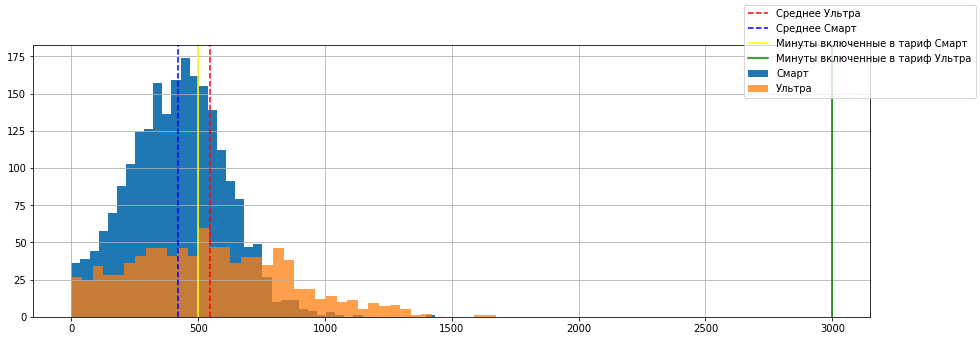

In [ ]:
fig, ax = plt.subplots() ##################

smart_call = data_pay[['user_id', 'tariff', 'month', 'duration_sum']]
smart_call = smart_call[smart_call['tariff'] =='smart'].reset_index(drop=True)

ultra_call = data_pay[['user_id', 'tariff', 'month', 'duration_sum']]
ultra_call = ultra_call[ultra_call['tariff'] =='ultra'].reset_index(drop=True)

print(' ')
print('Звонки')
print(' ')
print('Смарт')
smart_call['duration_sum'].hist(bins=40, label='Смарт', figsize=(15,5))
smart_call_variance = np.var(smart_call['duration_sum'],ddof=1)
print('Дисперсия:',smart_call_variance.round())
smart_call_std = np.std(smart_call['duration_sum'],ddof=1)
print('Стандартное отклонение:',smart_call_std.round())
smart_call_mean = smart_call['duration_sum'].mean()
print('Среднее:',smart_call_mean.round())

print(' ')
print('Ультра')
ultra_call['duration_sum'].hist(bins=40, alpha=0.75, label='Ультра')
ultra_call_variance = np.var(ultra_call['duration_sum'],ddof=1)
print('Дисперсия:',ultra_call_variance.round())
ultra_call_std = np.std(ultra_call['duration_sum'],ddof=1)
print('Стандартное отклонение:',ultra_call_std.round())
ultra_call_mean = ultra_call['duration_sum'].mean()
print('Среднее:',ultra_call_mean.round())

plt.axvline(ultra_call_mean, color='red', linestyle='--', label='Среднее Ультра')
plt.axvline(smart_call_mean, color='blue', linestyle='--', label='Среднее Смарт')

plt.axvline(500, color='yellow', label='Минуты включенные в тариф Смарт')
plt.axvline(3000, color='green', label='Минуты включенные в тариф Ультра')


fig.legend() ##################

Зеленая граница - количество минут включенное в тариф Ультра. Мы наглядно видим, что все распределение заканчивается далеко от этой границы. Пользователи даже близко не расходуют весь объем квлюченных минут.
Чтобы раглядеть график подробнее откажемся от изображения этой границы. Главные выводы о ней мы уже сделали.

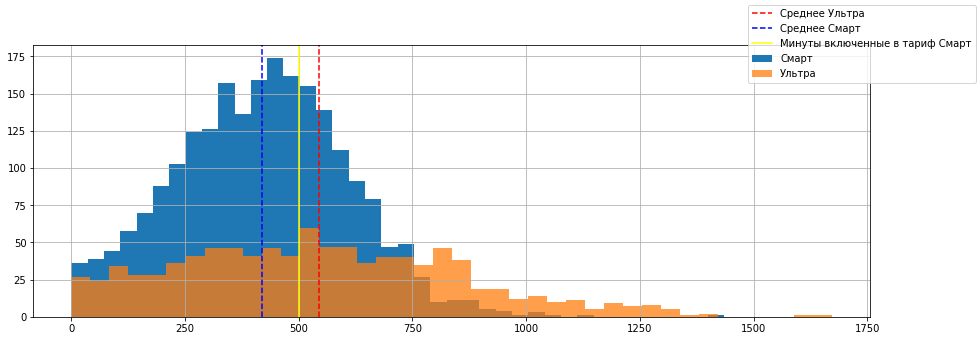

In [ ]:
fig, ax = plt.subplots() ##################

smart_call['duration_sum'].hist(bins=40, label='Смарт', figsize=(15,5))
ultra_call['duration_sum'].hist(bins=40, alpha=0.75, label='Ультра')

plt.axvline(ultra_call_mean, color='red', linestyle='--', label='Среднее Ультра')
plt.axvline(smart_call_mean, color='blue', linestyle='--', label='Среднее Смарт')

plt.axvline(500, color='yellow', label='Минуты включенные в тариф Смарт')

fig.legend() ##################

На графике мы видим 2 гистограммы. Синяя по тарифу Смарт, оранжевая - Ультра.
Оба распределены нормально, на сколько это возможно при столь небольшой выборке. 

Гистограмма тарифа Ультра более пологая, растянутая по оси Х, имеет большую дисперсию и большее стандартное отклонение, что говорит о том, что значения достаточно широко раскинуты относительно среднего в 516 минут в месяц.

Кроме того, на предыдущем графике мы видели, что граница включенных в тариф минут лежит далеко от распределения выборки, то есть с уверенностью можно сказать, что пользователи тарифа Ультра никогда не доплачивают за дополнительные минуты, более того, они и влюченные минуты никогда не используют.

Расчитаем величину в 3 Сигмы, чтобы понять оптимальную границу включенных минут для пользователей тарифа Ультра:

In [ ]:
(ultra_call_mean + ultra_call_std*3).round()

1466.0

Если бы в тарифе Ультра было включено 1466 минут, то пользователи не переплачивали бы за лишние минуты разговора.  
Выходит, что для пользователя выгодно выбирать тариф с границей включенных данный (минут, смс, гб) относительно 3 сигм. А для оператора что выгодно?

Гистограмма тарифа Смарт более крутая, что говорит о том, что данные ближе расположены относительно среднего, все пользователи имеют близкое количество минут разговора.
Однако, мы видим, что граница включеных минут проходит не далеко от среднего, а значит немногим меньше половины пользователей ежемесячно доплачивают за дополнительные минуты разговора. Что с точки зрения оператора, конечно, на руку.
Выходит, что для оператора выгодно, чтобы граница включенныого пакета данных проходила по среднему значению.



Теперь оценим количество сообщений потраченых пользователями в каждом из тарифов.

 
Сообщения
 
Смарт
Дисперсия: 718.0
Стандартное отклонение: 27.0
Среднее: 39.0
 
Ультра
Дисперсия: 2110.0
Стандартное отклонение: 46.0
Среднее: 61.0


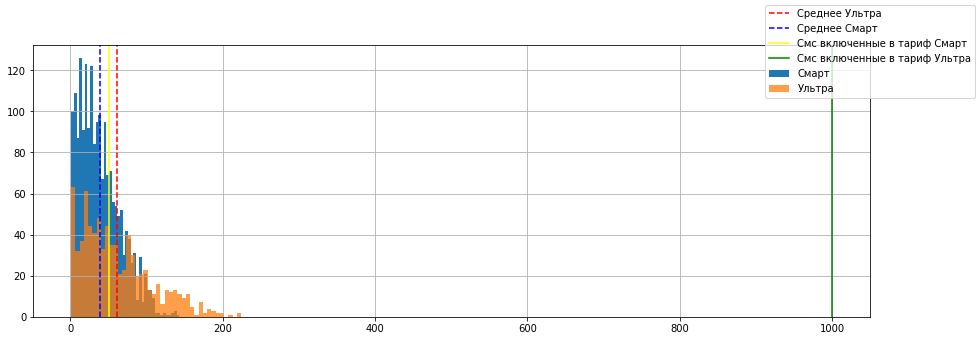

In [ ]:
fig, ax = plt.subplots() ##################

smart_messages = data_pay[['user_id', 'tariff', 'month', 'messages']]
smart_messages = smart_messages[smart_messages['tariff'] =='smart'].reset_index(drop=True)

ultra_messages = data_pay[['user_id', 'tariff', 'month', 'messages']]
ultra_messages = ultra_messages[ultra_messages['tariff'] =='ultra'].reset_index(drop=True)

print(' ')
print('Сообщения')
print(' ')
print('Смарт')
smart_messages['messages'].hist(bins=40, label='Смарт', figsize=(15,5))
smart_messages_variance = np.var(smart_messages['messages'],ddof=1)
print('Дисперсия:',smart_messages_variance.round())
smart_messages_std = np.std(smart_messages['messages'],ddof=1)
print('Стандартное отклонение:',smart_messages_std.round())
smart_messages_mean = smart_messages['messages'].mean()
print('Среднее:',smart_messages_mean.round())

print(' ')
print('Ультра')
ultra_messages['messages'].hist(bins=40, alpha=0.75, label='Ультра')
ultra_messages_variance = np.var(ultra_messages['messages'],ddof=1)
print('Дисперсия:',ultra_messages_variance.round())
ultra_messages_std = np.std(ultra_messages['messages'],ddof=1)
print('Стандартное отклонение:',ultra_messages_std.round())
ultra_messages_mean = ultra_messages['messages'].mean()
print('Среднее:',ultra_messages_mean.round())

plt.axvline(ultra_messages_mean, color='red', linestyle='--', label='Среднее Ультра')
plt.axvline(smart_messages_mean, color='blue', linestyle='--', label='Среднее Смарт')

plt.axvline(50, color='yellow', label='Смс включенные в тариф Смарт')
plt.axvline(1000, color='green', label='Смс включенные в тариф Ультра')


fig.legend() ##################

Аналогично с минутами, видим что и для сообщений граница включенных в пакет тарифа Ультра лежит очень далеко от распределения.
Откажемся от ее изображения, чтобы лучше рассмотреть график.

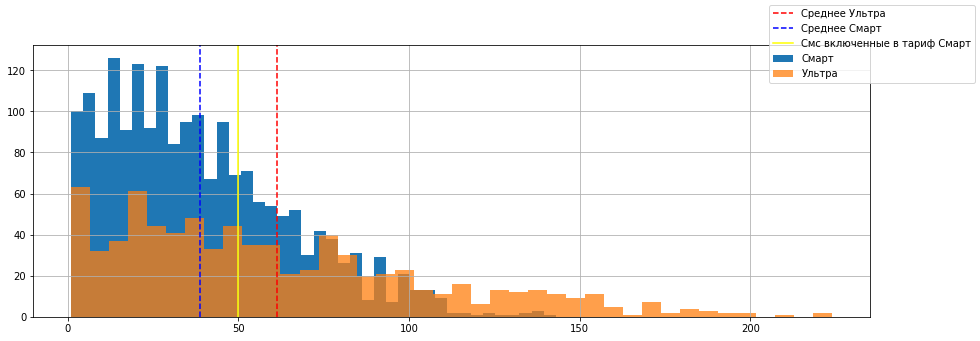

In [ ]:
fig, ax = plt.subplots() ##################

smart_messages['messages'].hist(bins=40, label='Смарт', figsize=(15,5))
ultra_messages['messages'].hist(bins=40, alpha=0.75, label='Ультра')
plt.axvline(ultra_messages_mean, color='red', linestyle='--', label='Среднее Ультра')
plt.axvline(smart_messages_mean, color='blue', linestyle='--', label='Среднее Смарт')

plt.axvline(50, color='yellow', label='Смс включенные в тариф Смарт')

fig.legend() ##################

На графиках видно, что оба они скошенные, то есть распределены не нормально. Оба скошены вправо, то есть распределения с положительной скошенностью.Это означает, что для данных распределений медиана будет меньше стреднего.  
О чем все это нам говорит в контекте данного исследования?  
О том, что пользователи в целом практически не пользуются смс, все сидят в мессаджерах, и включая большой пакет смс оператор повышает цену, а пользователь им практически не пользуется.

Однако, стоит заметить, что в тарифе Смарт все-таки достаточное количество клиентов превышает допустимое количество квлюченных сообщений и доплачивает за дополнительные сообщения. В тарифе Ультра, конечно, такого не происходит, слишком велика граница.



Посмотрим такие же данные по расходу интернет трафика.

 
Интернет трафик
 
Смарт
Дисперсия: 33.0
Стандартное отклонение: 6.0
Среднее: 16.0
 
Ультра
Дисперсия: 94.0
Стандартное отклонение: 10.0
Среднее: 20.0


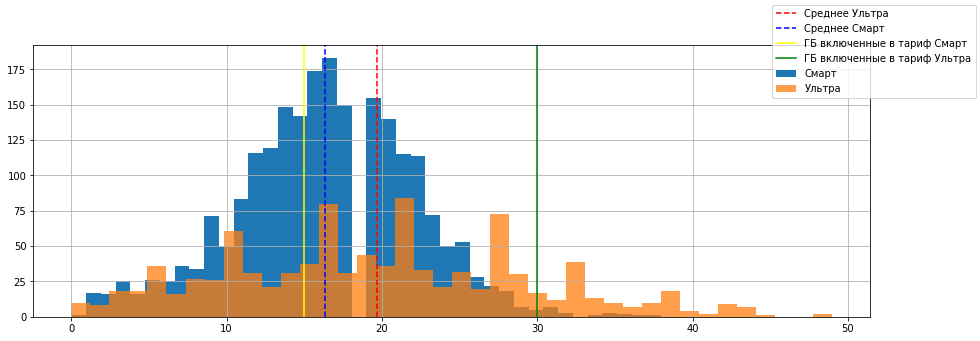

In [ ]:
fig, ax = plt.subplots() ##################

smart_internet = data_pay[['user_id', 'tariff', 'month', 'mb_used_sum']]
smart_internet = smart_internet[smart_internet['tariff'] =='smart'].reset_index(drop=True)

ultra_internet = data_pay[['user_id', 'tariff', 'month', 'mb_used_sum']]
ultra_internet = ultra_internet[ultra_internet['tariff'] =='ultra'].reset_index(drop=True)

print(' ')
print('Интернет трафик')
print(' ')
print('Смарт')
smart_internet['mb_used_sum'].hist(bins=40, label='Смарт', figsize=(15,5))
smart_internet_variance = np.var(smart_internet['mb_used_sum'],ddof=1)
print('Дисперсия:',smart_internet_variance.round())
smart_internet_std = np.std(smart_internet['mb_used_sum'],ddof=1)
print('Стандартное отклонение:',smart_internet_std.round())
smart_internet_mean = smart_internet['mb_used_sum'].mean()
print('Среднее:',smart_internet_mean.round())

print(' ')
print('Ультра')
ultra_internet['mb_used_sum'].hist(bins=40, alpha=0.75, label='Ультра')
ultra_internet_variance = np.var(ultra_internet['mb_used_sum'],ddof=1)
print('Дисперсия:',ultra_internet_variance.round())
ultra_internet_std = np.std(ultra_internet['mb_used_sum'],ddof=1)
print('Стандартное отклонение:',ultra_internet_std.round())
ultra_internet_mean = ultra_internet['mb_used_sum'].mean()
print('Среднее:',ultra_internet_mean.round())

plt.axvline(ultra_internet_mean, color='red', linestyle='--', label='Среднее Ультра')
plt.axvline(smart_internet_mean, color='blue', linestyle='--', label='Среднее Смарт')

plt.axvline(15, color='yellow', label='ГБ включенные в тариф Смарт')
plt.axvline(30, color='green', label='ГБ включенные в тариф Ультра')


fig.legend() ##################

Графики данных по интернет графику обоих тарифов распределены нормально, гистограмма тарифа Ультра снова более пологая, а Смарт - более крутой.
Для тарифа Смарт граница включенных в тариф гигабайт даже ниже, чем среднее. На тарифе Ультра пользователи также выходят за границу. Интернета пользователям явно мало, но при этом они охотно доплачивают за него и не переходят на тариф включающий в себя больший пакет.


И наконец оценим самое главное - выручку с клиентов по каждому из тарифов.

 
Выручка
 
Смарт
Дисперсия: 669731.0
Стандартное отклонение: 818.0
Среднее: 1290.0
 
Ультра
Дисперсия: 141388.0
Стандартное отклонение: 376.0
Среднее: 2070.0


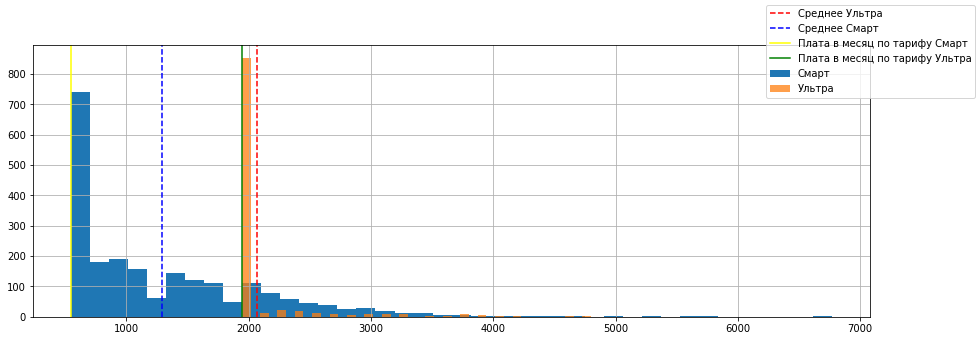

In [ ]:
fig, ax = plt.subplots() ##################

smart_payment = data_pay[['user_id', 'tariff', 'month', 'pay']]
smart_payment = smart_payment[smart_payment['tariff'] =='smart'].reset_index(drop=True)

ultra_payment = data_pay[['user_id', 'tariff', 'month', 'pay']]
ultra_payment = ultra_payment[ultra_payment['tariff'] =='ultra'].reset_index(drop=True)

print(' ')
print('Выручка')
print(' ')
print('Смарт')
smart_payment['pay'].hist(bins=40, label='Смарт', figsize=(15,5))
smart_payment_variance = np.var(smart_payment['pay'],ddof=1)
print('Дисперсия:',smart_payment_variance.round())
smart_payment_std = np.std(smart_payment['pay'],ddof=1)
print('Стандартное отклонение:',smart_payment_std.round())
smart_payment_mean = smart_payment['pay'].mean()
print('Среднее:',smart_payment_mean.round())

print(' ')
print('Ультра')
ultra_payment['pay'].hist(bins=40, alpha=0.75, label='Ультра')
ultra_payment_variance = np.var(ultra_payment['pay'],ddof=1)
print('Дисперсия:',ultra_payment_variance.round())
ultra_payment_std = np.std(ultra_payment['pay'],ddof=1)
print('Стандартное отклонение:',ultra_payment_std.round())
ultra_payment_mean = ultra_payment['pay'].mean()
print('Среднее:',ultra_payment_mean.round())

plt.axvline(ultra_payment_mean, color='red', linestyle='--', label='Среднее Ультра')
plt.axvline(smart_payment_mean, color='blue', linestyle='--', label='Среднее Смарт')

plt.axvline(550, color='yellow', label='Плата в месяц по тарифу Смарт')
plt.axvline(1950, color='green', label='Плата в месяц по тарифу Ультра')


fig.legend() ##################

Эти гистограммы тоже скошены вправо.Очевидно, что большенство клиентов все-таки стараются не выходить за пределы включенных пакетов и платят лишь абонентскую плату.  
  
Лучше всего это получается у пользователей тарифа Ультра, огромный столбец на отметке 1950 руб говорит о тем, что пользователи тарифа Ультра практически никогда не доплачивают за дополнительные услуги.  
  
Тогда как пользователи тарифа Смарт делают это систематически. И при этом средние счета некоторых пользователей превышают даже плату клиентов тарифа Ультра.  
  
Это наглядная иллюстрация скошенности распределения данных. Не смотря на то, что медиана будет маленькой, есть пользователи готовые платить гораздо больше, чем в тарифе Ультра.

Так какой же тариф принес большую сумму за год?

In [ ]:
print('Смарт:', smart_payment['pay'].sum(), 'рублей за год')
print('Ультра:', ultra_payment['pay'].sum(), 'рублей за год')

Смарт: 2875901.0 рублей за год
Ультра: 2041050.0 рублей за год


In [ ]:
'{:.0%}'.format((2666523/2030550)-1)

'31%'

Не смотря на то, что пользователи тарифа Ультра переплачивают за неисмпользуемые минуты разговора, смс, да в придачу еще иногда им приходится платить за недостаток трафика, они  приносят компании на 31% меньше прибыли в сравнении с тарифом Смарт.

### Вывод

Проведя исследование мложно сделать следующие выводы:
- Тариф Смарт более многочисленный в сравнении с тарифом Ультра. Тарифом Смарт пользуется 351 клиент, а Ультра 149.
- Для оператора выгодно, чтобы колисество включеных единиц в пакете было равно среднему импользуемому. Чтобы в среднем "умещался" по тратам, но систематически доплачивал за дополнительные единицы связи.
- Для клиента же выгоднее бы было, если бы границы тарифа устанавливались в районе 3 сигм.
- Пользователи почти не пользуются сообщениями, при этом активно используют интернет трафик и охотно доплачивают за него при превышении лимитов.
- Клиенты тарифа Ультра в основном платят только абонентскую плату и не превышают лимитов, тогда как пользователи тарифа Смарт систематически доплачивают.
- Клиенты тарифа Смарт приносят на 31% больше прибыли в сравнении с клиентами тарифа Ультра.

## Шаг 4. Проверка гипотиз.

На данном этапе нам неободимо проверить две гипотизы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Начнем с первой "средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются".
Возьмем за нулевую гипотезу H0 утверждение "средняя выручка пользователей тарифов «Ультра» и «Смарт» равны".
В таком случае двусторонней альтернативной гипотезой H1 будет - "средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются". Нам не важно что будет меньше, а что больше. Главное, что они не равны.

Нам нужно посчитать вероятность того, что средняя выручка пользователей по тарифу Смарт равна средней выручке пользователей по тарифу Ультра. Для этого воспользуемся тестом `scipy.stats.ttest_ind`.
Пороговое значение альфа примем равным 0,05.

In [ ]:
ultra = ultra_payment.groupby(['user_id'], as_index=False).agg({'pay': 'mean'})
smart = smart_payment.groupby(['user_id'], as_index=False).agg({'pay': 'mean'})
alpha = 0.05

results = st.ttest_ind(smart['pay'], ultra['pay'])

print(' ')
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

 
p-значение:  1.4760419872988006e-40
Отвергаем нулевую гипотезу


Полученое значение  p-value говорит о том, что вероятность того, что средняя выручка пользователей тарифов Смарт и Ультра практически равно нулю. Это означает, что нулевую гиполезу мы отвергаем и можем с некоторой долей вероятности утверждать, что да, средняя выручка пользователей разных тарифов отличается.  
   
     
   
Теперь проверим вторую гипотизу "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов".
Объявим нулевую гипотизу H0 утверждение "средняя выручка пользователей из Москвы равна выручке пользователей из других регионов", соответственно альтернативная двустороняя гипотеза H1 будет - "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов".

Точно так же как и в прошлый раз раз воспользуемся тестом `scipy.stats.ttest_ind`.
Пороговое значение альфа примем равным 0,05.

In [ ]:
moscow = data_pay[['user_id', 'pay']]
moscow = moscow.merge(users[['city', 'user_id']], on = 'user_id', how='left')
moscow = moscow[moscow['city'] == 'Москва']
moscow = moscow.groupby(['user_id'], as_index=False).agg({'pay': 'mean'})


region = data_pay[['user_id', 'pay']]
region = region.merge(users[['city', 'user_id']], on = 'user_id', how='left')
region = region[region['city'] != 'Москва']
region = region.groupby(['user_id'], as_index=False).agg({'pay': 'mean'})

alpha = 0.05

results = st.ttest_ind(moscow['pay'], region['pay'])

print(' ')
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

 
p-значение:  0.37273509521850456
Не получилось отвергнуть нулевую гипотезу


Исходя из полученного значения p-value можно сделать вывод, что вероятность того, что средняя выручка пользователей из Москвы равна выручке пользователей из других регионов составляет аж 37%. Соотвественно нулевую гипотезу опровергнуть не удалось и с определенной долей вероятности мы можем утверждать, что выручка не зависит от того, в Москве проживает пользователь или в регионе.

## Общий вывод.

Мы провели исследование данных за 2018 год федерального оператора сотовой связи "Мегалайн", предлагающего своим клиентам два тарифных плана «Смарт» и «Ультра».
В рамках исследования были выделены следующие факты:
- Более дешевым тарифом Смарт пользуется большее количество пользователей.
- Клиента пости не используют сообщения, зато активно пользуется интернет трафиком и охотно доплачивают за него при окончании лимита.
- Клиенты тарифа Смарт систематически доплачивают за дополнительные единицы связи, тогда как пользователи Ультра чаще всего используют намного меньше установленного лимита.
- Несмотря на постоянные доплаты средняя плата за месяц дла клиентов тарифа Смарт все равно остается ниже платы клиентов тарифа Ультра.
- Общая прибыль компании с пользователей тарифа Смарт на 31% выше прибыли с клиентов тарифа Ультра.  
   
Проверив две гипотезы мы выяснили, что вероятность того, что выручка с клиентов тарифов Смарт и Ультра будет равна - правктически нулевая. А также вероятность что средняя выручка Москвы и регионов не отличается составляет аж 40%.
Выходит, что с некоторой долей вероятности мы можем утверждать, что средняя выручка на тарифах Смарт и Ультра будут различаться и что выручка не будет зависить от места жительства клиента.

